In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### 1. Loading Data

Dataset : https://www.kaggle.com/kartik2112/fraud-detection

In [3]:
df_train = pd.read_csv('data/fraudTrain.csv')
df_test = pd.read_csv('data/fraudTest.csv')

In [4]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### 2. Exploratory Data Analysis

In [5]:
print('Shape of train data : ', df_train.shape)
print('Shape of test data : ', df_test.shape)

Shape of train data :  (1296675, 23)
Shape of test data :  (555719, 23)


In [6]:
# taking smaller sample to run the model faster

df_train= df_train.sample(frac = 0.1,random_state=1)
df_test= df_test.sample(frac = 0.05,random_state=1)
print(df_train.shape, df_test.shape)

(129668, 23) (27786, 23)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129668 entries, 94102 to 1171139
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129668 non-null  int64  
 1   trans_date_trans_time  129668 non-null  object 
 2   cc_num                 129668 non-null  int64  
 3   merchant               129668 non-null  object 
 4   category               129668 non-null  object 
 5   amt                    129668 non-null  float64
 6   first                  129668 non-null  object 
 7   last                   129668 non-null  object 
 8   gender                 129668 non-null  object 
 9   street                 129668 non-null  object 
 10  city                   129668 non-null  object 
 11  state                  129668 non-null  object 
 12  zip                    129668 non-null  int64  
 13  lat                    129668 non-null  float64
 14  long                   129668 n

#### Checking Correlation:

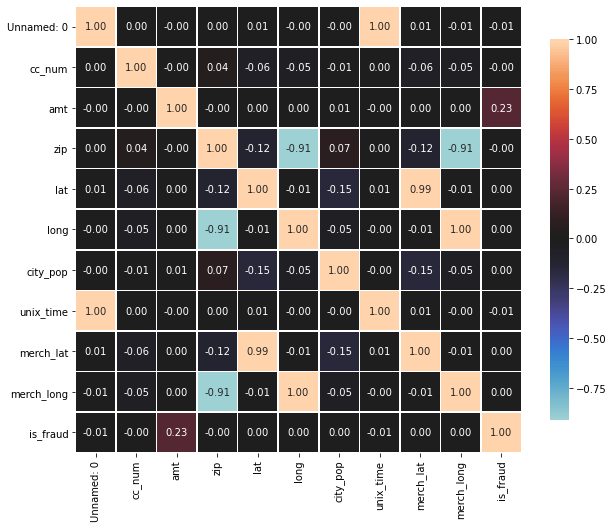

In [8]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df_train)

#### Exploring the Data distribution for all the fields


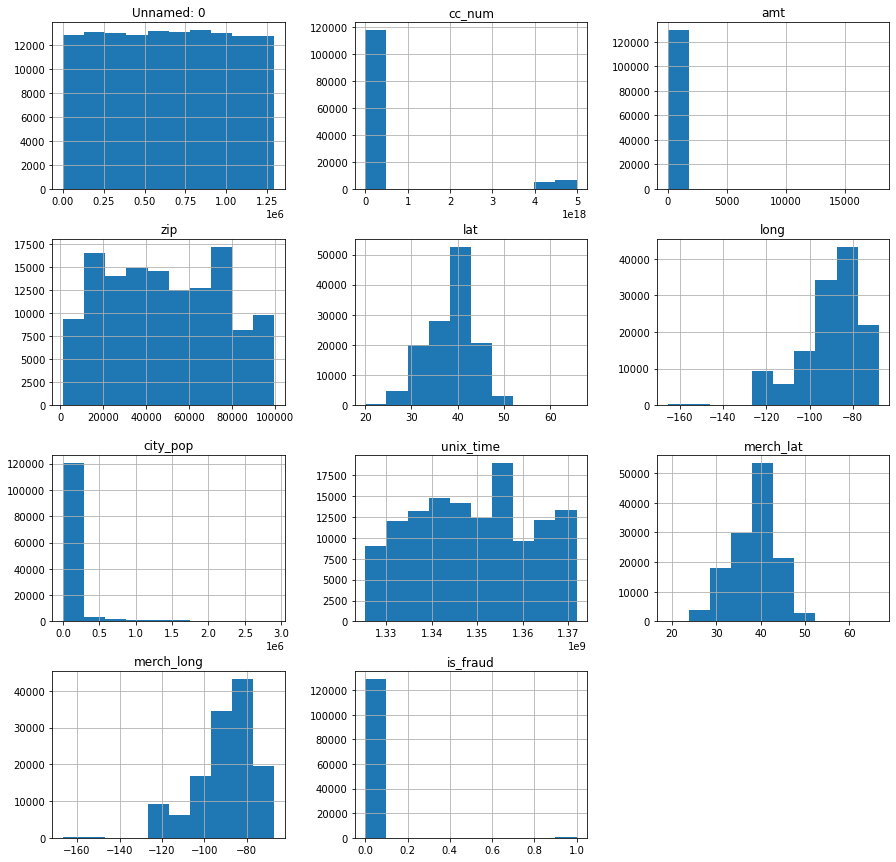

In [9]:
# Checking distribution of the data using histograms 

df_train.hist(figsize = (15, 15))
plt.show()

#### Data Distribution

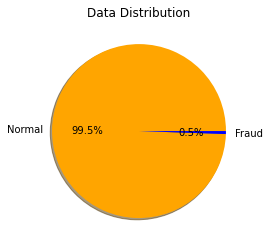

In [10]:
frequency = pd.value_counts(df_train['is_fraud'], sort = True)
distribution = [frequency[0], frequency[1]]
my_labels = 'Normal', 'Fraud'
my_colors = ['orange', 'blue']

plt.pie(distribution, labels=my_labels, autopct='%1.1f%%', colors=my_colors, shadow = True)
plt.title('Data Distribution')
plt.show()

We see that the data is highly imbalanced. Fraudulent transactions are only 0.5% of the total transactions.

In [11]:
## Total Fraud and the normal transactions for test and train dataset 

fraud_train = df_train[df_train['is_fraud']==1]
normal_train = df_train[df_train['is_fraud']==0]
fraud_test = df_test[df_test['is_fraud']==1]
normal_test = df_test[df_test['is_fraud']==0]

print("Normal cases in train set :", len(df_train)-len(fraud_train),"\nFraud cases in train set :",len(fraud_train))
print("Normal cases in test set :", len(df_test)-len(fraud_test),"\nFraud cases in test set :",len(fraud_test))


Normal cases in train set : 128963 
Fraud cases in train set : 705
Normal cases in test set : 27656 
Fraud cases in test set : 130


### 3. Data Transformation and Feature Engineering

#### Dropping fields that are not required

In [12]:
# Function to drop columns from the dataframe

def dropCol(data, columns):
    res = data.drop(columns, axis = 1)
    return res

In [13]:
# Dropping columns for both train and test dataset

col_to_drop = ['Unnamed: 0', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'zip', 'trans_num']

df_train = dropCol(df_train, col_to_drop)
df_test = dropCol(df_test, col_to_drop)

print(df_train.shape, df_test.shape)

(129668, 14) (27786, 14)


#### Adding new features

#### 1. Creating month, year, day and time column from transaction time

In [14]:
# 1. Splitting trans_date_trans_time to get date and time columns

df_train = df_train.join(df_train.trans_date_trans_time.str.split(" ", expand=True).add_prefix('spl'))
df_test =  df_test.join(df_test.trans_date_trans_time.str.split(" ", expand=True).add_prefix('spl'))

# 2. Splitting date to get year, month and date

df_train = df_train.join(df_train.spl0.str.split('-', expand=True).add_prefix('date'))
df_test = df_test.join(df_test.spl0.str.split('-', expand=True).add_prefix('date'))


In [15]:
# Renaming the columns

df_train = df_train.rename(columns={"spl0": "date", "spl1": "time", 'date0':'year', 'date1':'month', 'date2':'day'})
df_test = df_test.rename(columns={"spl0": "date", "spl1": "time", 'date0':'year', 'date1':'month', 'date2':'day'})


#### 2. Calculating age from dob

In [16]:
# Converting dob and transaction date into date time format and calculating the age

df_train['dob'] = pd.to_datetime(df_train['dob'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['dob'] = pd.to_datetime(df_test['dob'])
df_test['date'] = pd.to_datetime(df_test['date'])


df_train['age'] = (np.floor((df_train['date'] - df_train['dob']).dt.days) / 365.25).astype(int)
df_test['age'] = (np.floor((df_test['date'] - df_test['dob']).dt.days) / 365.25).astype(int)

#### 3. Discretizing time into bins

In [17]:
# Discretizing time into bins
df_train.time= pd.to_datetime(df_train.time)
df_test.time= pd.to_datetime(df_test.time)

# define the bins
bins = [0, 6, 12, 18, 24]

# add custom labels if desired
labels = ['0-6', '6-12', '12-18', '18-24']

# add the bins to the dataframe
df_train['time_bin'] = pd.cut(df_train.time.dt.hour, bins, labels=labels, right=False)
df_test['time_bin'] = pd.cut(df_test.time.dt.hour, bins, labels=labels, right=False)


In [18]:
# Dropping additional and repetitive columns

cols_to_drop = ['trans_date_trans_time', 'dob', 'unix_time', 'date', 'day', 'time']

df_train = dropCol(df_train, cols_to_drop)
df_test = dropCol(df_test, cols_to_drop)

#### Separating independent and dependent variables

In [19]:
# Separating the target variable
columns = [c for c in df_train.columns[:] if c not in ["is_fraud"]]

X_train = df_train[columns]
y_train = df_train['is_fraud']
X_test = df_test[columns]
y_test = df_test['is_fraud']


In [21]:
print ( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(129668, 14) (129668,) (27786, 14) (27786,)


In [22]:
X_train.head()

,category,amt,gender,state,lat,long,city_pop,job,merch_lat,merch_long,year,month,age,time_bin
94102,grocery_net,20.00,F,ND,47.1709,-100.7944,1190,"Designer, ceramics/pottery",46.398331,-99.813959,2019,02,70,6-12
198791,home,284.88,F,WA,46.5901,-117.1692,761,Chief Marketing Officer,45.687331,-117.488135,2019,04,75,18-24
1238587,shopping_net,5.07,F,FL,27.9551,-82.2966,79613,Environmental consultant,27.254081,-81.974799,2020,05,41,18-24
619078,food_dining,45.38,F,GA,34.0770,-84.3033,165556,Prison officer,34.551957,-83.374265,2019,09,21,12-18
573850,health_fitness,27.52,M,MI,43.6088,-83.9530,67858,Water quality scientist,43.032957,-83.521294,2019,08,24,18-24


#### Converting Categorical features to Numerical

In [24]:
# concatenating test and train data to ensure number of columns remain same

final_df = pd.concat([X_train, X_test],axis=0)
final_df.shape


(157454, 14)

In [25]:
# creating the list of categorical variables

categorical_features =[feature for feature in X_train.columns if final_df[feature].dtype.name == 'category' or final_df[feature].dtypes =='object']
categorical_features


['category', 'gender', 'state', 'job', 'year', 'month', 'time_bin']

In [26]:
for feature in categorical_features:
    print("Distinct categories for {}  are {}".format(feature,len(final_df[feature].unique())))

Distinct categories for category  are 14
Distinct categories for gender  are 2
Distinct categories for state  are 51
Distinct categories for job  are 486
Distinct categories for year  are 2
Distinct categories for month  are 12
Distinct categories for time_bin  are 4


In [27]:
# function to convert categorical variables to one hot encoding

def category_onehot_multcols(data,multcolumns):
    df_final = data
    i = 0
    for fields in multcolumns:
        print(fields)
        df1 = pd.get_dummies(final_df[fields], drop_first=True)
        final_df.drop([fields],axis=1, inplace=True)
        if i == 0:
            df_final = df1.copy()
        else:           
            df_final = pd.concat([df_final,df1], axis=1)
        i += 1             
    df_final = pd.concat([final_df, df_final], axis=1)
    return df_final

In [28]:
# applying the one hot encoding

final_df = category_onehot_multcols(final_df, categorical_features)

category
gender
state
job
year
month
time_bin


In [29]:
final_df.head()

,amt,lat,long,city_pop,merch_lat,merch_long,age,food_dining,gas_transport,grocery_net,...,06,07,08,09,10,11,12,6-12,12-18,18-24
94102,20.00,47.1709,-100.7944,1190,46.398331,-99.813959,70,0,0,1,...,0,0,0,0,0,0,0,1,0,0
198791,284.88,46.5901,-117.1692,761,45.687331,-117.488135,75,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1238587,5.07,27.9551,-82.2966,79613,27.254081,-81.974799,41,0,0,0,...,0,0,0,0,0,0,0,0,0,1
619078,45.38,34.0770,-84.3033,165556,34.551957,-83.374265,21,1,0,0,...,0,0,0,1,0,0,0,0,1,0
573850,27.52,43.6088,-83.9530,67858,43.032957,-83.521294,24,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [30]:
# removing duplicated columns

final_df = final_df.loc[:, ~final_df.columns.duplicated()]
final_df.shape

(157454, 571)

In [31]:
# separating the test and training data

df_train = final_df.iloc[:X_train.shape[0],:]
df_test = final_df.iloc[X_train.shape[0]:,:]
print(df_train.shape, df_test.shape)

(129668, 571) (27786, 571)


In [32]:
print(y_train.value_counts(),"\n", y_test.value_counts())

0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64


In [33]:
X_test.head()

,category,amt,gender,state,lat,long,city_pop,job,merch_lat,merch_long,year,month,age,time_bin
207181,kids_pets,41.17,M,KY,37.6848,-85.8784,48194,Surgeon,38.370429,-86.671765,2020,09,30,12-18
501018,misc_pos,51.89,M,OH,39.0965,-84.6431,177,Exhibition designer,39.090859,-84.115650,2020,12,46,6-12
312515,misc_net,2.22,F,MN,47.5375,-95.9941,516,Applications developer,47.285136,-96.180797,2020,10,54,6-12
407433,gas_transport,87.21,M,NY,41.1360,-73.7009,7987,Television/film/video producer,41.503596,-73.220229,2020,11,56,0-6
386454,misc_net,79.78,F,KY,38.6207,-83.8067,14228,Advertising account executive,39.043199,-83.842076,2020,11,49,6-12


#### Saving the processed data to files to use for modelling

In [34]:
# Save the data to csv files

df_train.to_csv("processed_train.csv")
df_test.to_csv("processed_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

In [42]:
df_train.describe()

,amt,lat,long,city_pop,merch_lat,merch_long,age,food_dining,gas_transport,grocery_net,...,06,07,08,09,10,11,12,6-12,12-18,18-24
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,...,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,7.035104e+01,3.853762e+01,-9.022634e+01,8.882444e+04,3.853734e+01,-9.022646e+01,4.549541e+01,7.053502e-02,1.015359e-01,3.505273e-02,...,1.109075e-01,6.678312e-02,6.737155e-02,5.448705e-02,5.302639e-02,5.430891e-02,1.087859e-01,1.955355e-01,3.023294e-01,3.056093e-01
std,1.603160e+02,5.075808e+00,1.375908e+01,3.019564e+05,5.109788e+00,1.377109e+01,1.739698e+01,2.560466e-01,3.020371e-01,1.839132e-01,...,3.140177e-01,2.496461e-01,2.506645e-01,2.269763e-01,2.240862e-01,2.266263e-01,3.113706e-01,3.966125e-01,4.592674e-01,4.606652e-01
min,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,1.902779e+01,-1.666712e+02,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.650000e+00,3.462050e+01,-9.679800e+01,7.430000e+02,3.473357e+01,-9.689728e+01,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.752000e+01,3.935430e+01,-8.747690e+01,2.456000e+03,3.936568e+01,-8.743839e+01,4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.314000e+01,4.194040e+01,-8.015800e+01,2.032800e+04,4.195716e+01,-8.023680e+01,5.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,6.751027e+01,-6.695090e+01,9.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [45]:
# Standardization or z-score normalization : centering the variable at zero and standardizing the variance at 1.

scaler = StandardScaler() 
df_train_scaled = scaler.fit_transform(df_train)

In [47]:
df_train_scaled

array([[-0.40782607, -0.48441989,  0.65761961, ..., -0.49301414,
        -0.65828658, -0.66340904],
       [ 0.23003923,  2.03911997, -2.03387012, ..., -0.49301414,
        -0.65828658, -0.66340904],
       [ 0.93414872,  0.7177536 , -1.60153717, ..., -0.49301414,
        -0.65828658, -0.66340904],
       ...,
       [ 0.22193025, -1.10288318, -1.13325703, ..., -0.49301414,
         1.51909523, -0.66340904],
       [ 0.02837499,  0.94861347, -0.89502874, ..., -0.49301414,
         1.51909523, -0.66340904],
       [-0.41200532,  1.43931381, -1.71875438, ..., -0.49301414,
         1.51909523, -0.66340904]])

In [48]:
type(df_train_scaled)

numpy.ndarray